## Introduction

Overfitting is a common problem in neural networks, where the model performs well on the training data but poorly on the test data. This is because the model has learned the noise in the training data, rather than the underlying pattern. Common reasons for overfitting include using a model that is too complex, not having enough training data, and training for too many epochs. There are several ways to reduce overfitting, such as using dropout, early stopping, and data augmentation. In this notebook, we will explore some of these techniques and see how they can be used to improve the performance of a neural network.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam
from keras.losses import categorical_crossentropy, sparse_categorical_crossentropy
from tensorflow.keras import backend as K
from keras.models import load_model
from keras.utils import to_categorical, plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
import imageio.v3 as iio
import os
import shutil
from glob import glob
from sklearn.model_selection import GridSearchCV
from PIL import Image
from tqdm import tqdm
from pygifsicle import optimize
from scikeras.wrappers import KerasRegressor
from scikeras.wrappers import KerasClassifier

In [ ]:
files_layers = glob("../data/OptimisedNN/sin/layers/*")
files_ratios = glob("../data/OptimisedNN/sin/ratios/*")

layer_gif = "../data/OptimisedNN/sin/layers/layers.gif"
ratio_gif = "../data/OptimisedNN/sin/ratios/ratios.gif"

for file in files_layers:
    shutil.rmtree(file)
for file in files_ratios:
    shutil.rmtree(file)

## Classification

We now analyze overfitting on a classification problem using the MNIST dataset.

In [ ]:
(x_minst_train, y_minst_train), (x_minst_test, y_minst_test) = mnist.load_data()
assert x_minst_train.shape == (60000, 28, 28)
assert x_minst_test.shape == (10000, 28, 28)
assert y_minst_train.shape == (60000,)
assert y_minst_test.shape == (10000,)

In [ ]:
x = np.concatenate((x_minst_train, x_minst_test), axis=0).reshape(-1, 784).astype("float32") / 255.0
y = np.concatenate((y_minst_train, y_minst_test), axis=0)
y = keras.utils.to_categorical(y)

In [ ]:
def create_model_classification(n_hidden_layers):
    model = Sequential()
    model.add(Dense(16, activation="relu", input_shape=(784,)))
    for _ in range(n_hidden_layers):
        model.add(Dense(10, activation="relu"))
    model.add(Dense(10, activation="softmax"))

    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

We now analyze different hyperparameters to see their effect on the model performance.

### Effect of Train Test Ratio

In [ ]:
loss_train = []
loss_test = []
accuracy_train = []
accuracy_test = []


x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.05, shuffle=True)
n = int(0.15 * 70000)

for i in range(7):
    model = create_model_classification(3)

    model.fit(x_train, y_train, epochs=15, verbose=0, batch_size=4000)

    train_loss, train_accuracy = model.evaluate(x_train, y_train)
    test_loss, test_accuracy = model.evaluate(x_test, y_test)

    loss_train.append(train_loss)
    loss_test.append(test_loss)
    accuracy_train.append(train_accuracy)
    accuracy_test.append(test_accuracy)

    x_train = np.concatenate((x_train, x_test[:n]), axis=0)
    y_train = np.concatenate((y_train, y_test[:n]), axis=0)
    x_test = x_test[n:]
    y_test = y_test[n:]

110/110 [==============================] - 0s 700us/step - loss: 0.3487 - accuracy: 0.9040


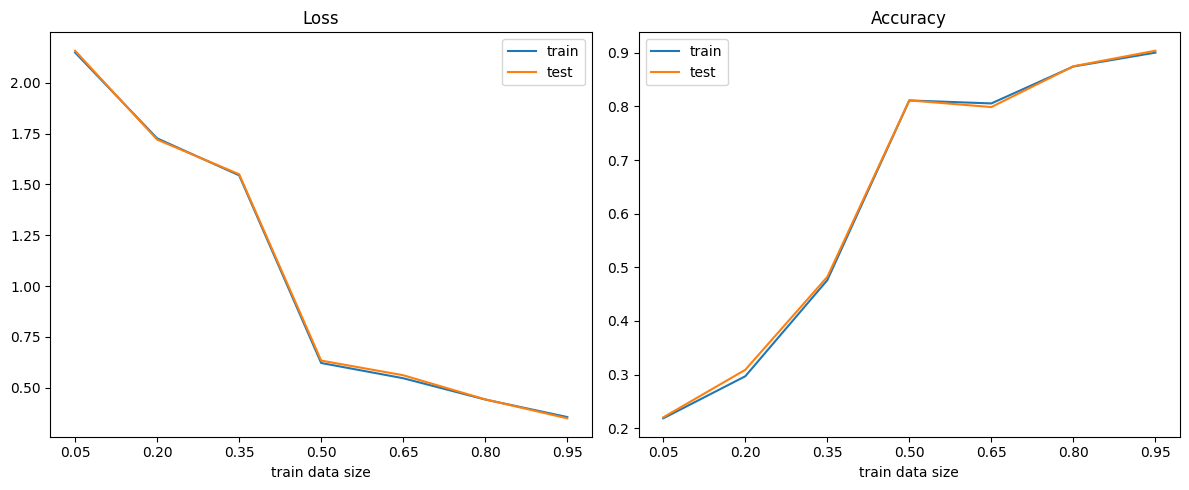

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
sizes = [0.05, 0.2, 0.35, 0.5, 0.65, 0.8, 0.95]

axes[0].plot(sizes, loss_train, label="train")
axes[0].plot(sizes, loss_test, label="test")
axes[0].set_title("Loss")
axes[0].set_xlabel("train data size")
axes[0].set_xticks(sizes)
axes[0].legend()

axes[1].plot(sizes, accuracy_train, label="train")
axes[1].plot(sizes, accuracy_test, label="test")
axes[1].set_title("Accuracy")
axes[1].set_xlabel("train data size")
axes[1].set_xticks(sizes)
axes[1].legend()

plt.tight_layout()
plt.show()

### Effect of number of Layers

#### without changing batch size

In [ ]:
losses = []
accuracies = []

layers = list(range(3, 21))
for i in layers:
    model = create_model_classification(n_hidden_layers = i)
    model.fit(x, y, batch_size=4000, epochs=10, verbose = False)
    
    loss, accuracy = model.evaluate(x, y)

    accuracies.append(accuracy)
    losses.append(loss)

2188/2188 [==============================] - 2s 787us/step - loss: 2.3011 - accuracy: 0.1125


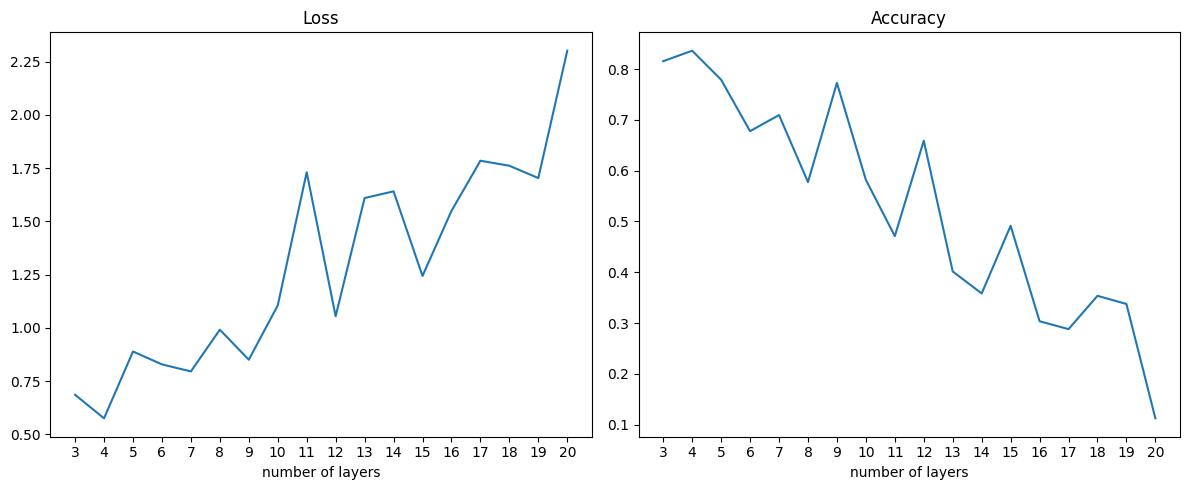

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

axes[0].plot(layers, losses, label="train")
axes[0].set_title("Loss")
axes[0].set_xlabel("number of layers")
axes[0].set_xticks(layers)

axes[1].plot(layers, accuracies)
axes[1].set_title("Accuracy")
axes[1].set_xlabel("number of layers")
axes[1].set_xticks(layers)


plt.tight_layout()
plt.show()

#### with changing batch size

In [ ]:
losses = []
accuracies = []

layers = list(range(3, 21))
for i in layers:
    model = create_model_classification(n_hidden_layers=i)
    model.fit(x, y, batch_size=4000, epochs=5 * i, verbose=False)

    loss, accuracy = model.evaluate(x, y)

    accuracies.append(accuracy)
    losses.append(loss)

2188/2188 [==============================] - 2s 770us/step - loss: 0.2910 - accuracy: 0.9234


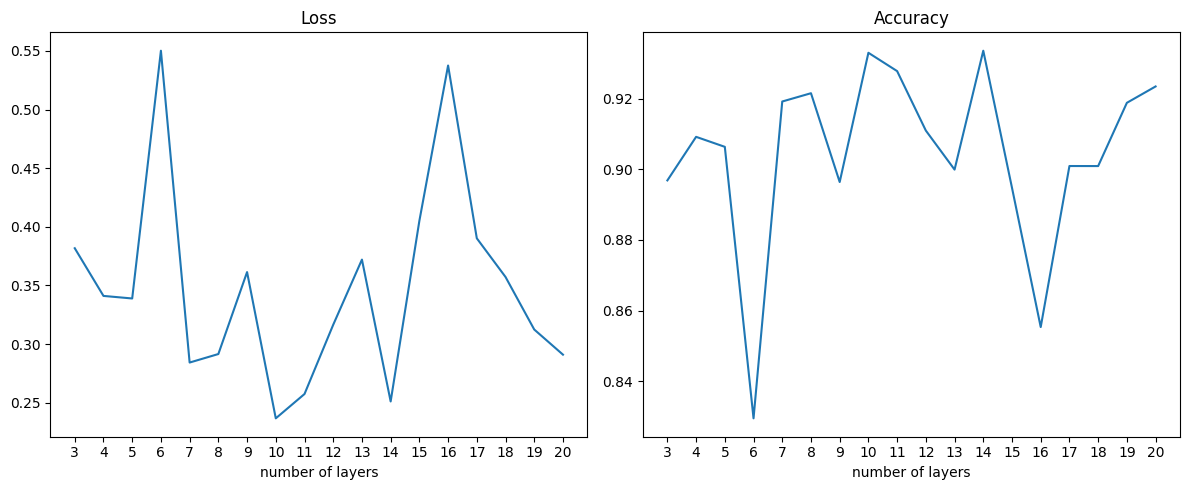

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

axes[0].plot(layers, losses, label="train")
axes[0].set_title("Loss")
axes[0].set_xlabel("number of layers")
axes[0].set_xticks(layers)

axes[1].plot(layers, accuracies)
axes[1].set_title("Accuracy")
axes[1].set_xlabel("number of layers")
axes[1].set_xticks(layers)


plt.tight_layout()
plt.show()

### Grid Search for Optimal

In [ ]:
def create_optimal(units=64):
    model = Sequential()
    model.add(Dense(units, activation="relu", input_shape=(784,)))
    model.add(Dense(10, activation="softmax"))
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model


units = [32, 64, 128]
param_grid = {
    "units": units, 
    "batch_size": [128, 256], 
    "epochs": [10, 20]
}

model = KerasClassifier(model=create_optimal, verbose=0, units=units)


x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, shuffle=True)

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(x_train, y_train)
grid.score(x_test, y_test)

0.9750714285714286

In [ ]:
results = pd.DataFrame(grid_result.cv_results_)
results = results[["params", "mean_test_score"]]
results.sort_values("mean_test_score", ascending=False, inplace=True)
results.reset_index(drop=True, inplace=True)
results

,params,mean_test_score
0,"{'batch_size': 128, 'epochs': 20, 'units': 128}",0.973107
1,"{'batch_size': 256, 'epochs': 20, 'units': 128}",0.971696
2,"{'batch_size': 128, 'epochs': 10, 'units': 128}",0.970446
3,"{'batch_size': 128, 'epochs': 20, 'units': 64}",0.969304
4,"{'batch_size': 256, 'epochs': 20, 'units': 64}",0.967304
5,"{'batch_size': 256, 'epochs': 10, 'units': 128}",0.967071
6,"{'batch_size': 128, 'epochs': 10, 'units': 64}",0.964214
7,"{'batch_size': 128, 'epochs': 20, 'units': 32}",0.960607
8,"{'batch_size': 256, 'epochs': 10, 'units': 64}",0.959089
9,"{'batch_size': 128, 'epochs': 10, 'units': 32}",0.954518


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.8, shuffle=True)

model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(784,)))
model.add(Dropout(0.2))  
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))  
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))  
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train, epochs=60, verbose=1, batch_size=1000)

train_loss, train_accuracy = model.evaluate(x_train, y_train)
test_loss, test_accuracy = model.evaluate(x_test, y_test)

Epoch 1/60
56/56 [==============================] - 2s 16ms/step - loss: 1.1408 - accuracy: 0.6263
Epoch 2/60
56/56 [==============================] - 1s 14ms/step - loss: 0.3938 - accuracy: 0.8924
Epoch 3/60
56/56 [==============================] - 1s 15ms/step - loss: 0.2679 - accuracy: 0.9279
Epoch 4/60
56/56 [==============================] - 1s 14ms/step - loss: 0.2067 - accuracy: 0.9458
Epoch 5/60
56/56 [==============================] - 1s 14ms/step - loss: 0.1684 - accuracy: 0.9548
Epoch 6/60
56/56 [==============================] - 1s 17ms/step - loss: 0.1461 - accuracy: 0.9620
Epoch 7/60
56/56 [==============================] - 1s 13ms/step - loss: 0.1269 - accuracy: 0.9668
Epoch 8/60
56/56 [==============================] - 1s 15ms/step - loss: 0.1112 - accuracy: 0.9706
Epoch 9/60
56/56 [==============================] - 1s 15ms/step - loss: 0.0992 - accuracy: 0.9735
Epoch 10/60
56/56 [==============================] - 1s 15ms/step - loss: 0.0891 - accuracy: 0.9762
Epoch 11/

In [ ]:
print(test_accuracy)

0.9816428422927856


We then searched for optimal neural network for MNIST on the internet and found these:

- [Optimizing Hyperparameters for the MNIST Dataset in CNN](https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/)

- [Optimizing Hyperparameters for the MNIST Dataset in javascript](https://medium.com/@martin_stoyanov/optimizing-hyperparameters-for-the-mnist-dataset-in-javascript-4cb8c17df940)


- [Optimizing Hyperparameters for the MNIST Dataset in python](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/multi-class_classification_with_MNIST.ipynb?hl=en#scrollTo=wYG5qXpP5a9n ) 

- [Optimize Neural Network on MNIST](https://arxiv.org/abs/2012.06898)